# Mask RCNN 2ND model for different augmentations --> 1.5 or so validation error

# Installing MaskRCNN and preliminary reqs

In [1]:
!git clone https://github.com/leekunhee/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 136.81 MiB | 24.67 MiB/s, done.
Resolving deltas: 100% (577/577), done.


In [ ]:
!python --version

Python 3.7.10


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/Mask_RCNN

/content/Mask_RCNN


In [4]:
!python setup.py install
#Installing mask rcnn

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:694: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:694: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:694: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'ma

EDIT THE REQUIREMENTS FILE AS FOLLLOWS
numpy
scipy
Pillow
cython
matplotlib
scikit-image
tensorflow==2.5.0
keras==2.4.3
opencv-python
h5py
imgaug
IPython[all]
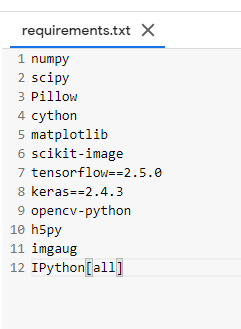

In [5]:
  !pip install -r requirements.txt
#Installing req

     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 204kB 18.8MB/s 


In [ ]:
#Check gpu
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Image Augmentation

In [ ]:
import imgaug as ia
ia.seed(1)
#IMG AUG IS USED FOR AUGMENTATION OF Bounding boxes and images
%matplotlib inline

from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 

# imageio for image I/O

import imageio
import pandas as pd
import numpy as np
import re
import os
import glob

# XML annotation reading

import xml.etree.ElementTree as ET
import shutil

## XML TO CSV

In [ ]:

# Converting xml to csv 

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df
# apply the function to convert all XML files in images/ folder into labels.csv
labels_df = xml_to_csv('/content/gdrive/My Drive/origannots')
labels_df.to_csv(('labels.csv'), index=None)
#Getting original annotations in CSV format

In [ ]:
labels_df.loc[labels_df['filename']=='0002.jpg']

,filename,width,height,class,xmin,ymin,xmax,ymax
228,0002.jpg,375,264,surname,129,25,151,41
229,0002.jpg,375,264,name,127,39,194,53
230,0002.jpg,375,264,country,127,53,182,68
231,0002.jpg,375,264,dob,126,65,185,80
232,0002.jpg,375,264,address,167,76,232,97
233,0002.jpg,375,264,cnic,248,65,327,83
234,0002.jpg,375,264,passno,249,9,303,29


## Image Resize + Bounding boxes resize

In [ ]:
# Height and width resize
#Resizing all images to 512
height_resize = iaa.Sequential([ 
    iaa.Resize({"height": 512, "width": 512})
])

# function to convert BoundingBoxesOnImage object into DataFrame
def bbs_obj_to_df(bbs_object):

    #convert BoundingBoxesOnImage object into array
    
    bbs_array = bbs_object.to_xyxy_array()

    #convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

In [ ]:
def resize_imgaug(df, images_path, aug_images_path):
    
    #df for augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')    
    count = 1
    for filename in df['filename'].unique():
    #Get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)

        #Resize all images to 512 x 512
        if True:
        #   read the image
            image = imageio.imread(images_path+filename)
        #   get bounding boxes coordinates and write into array        
            bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
            image_aug, bbs_aug = height_resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+str(count)+filename[-4:], image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: str(count)+x[-4:])
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])
            count = count+1
            
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    #Convert the values to float
    toc={'xmin':'int32','ymin':'int32','xmax':'int32','ymax':'int32'}
    aug_bbs_xy=aug_bbs_xy.astype(toc)
        
    return aug_bbs_xy

In [ ]:
resized_images_df = resize_imgaug(labels_df, '/content/gdrive/MyDrive/Original/','/content/gdrive/MyDrive/images1/')
#Resized images bounding boxes information

In [ ]:
resized_images_df.to_csv('/content/resized.csv', index=False)
#Store this as csv to  use for conversion to xml

In [ ]:
!pip install imgann
#Library for conversion to xml from csv file

In [ ]:
%cd ..
%cd ..

/content
/


In [ ]:
from imgann import Convertor
Convertor.csv2voc('/content/gdrive/My Drive/images1/','/content/resized.csv','/content/gdrive/My Drive/aimages1')
#Converting csv to voc xml > image location, file location, output location

## Various augmentation filters

In [ ]:
# For augmenting the images by rotation across axis
# Same as resize function but with a loop for different augmentations

def image_aug(df, images_path, aug_images_path):
    
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')
    count = 49
    for filename in df['filename'].unique():
    
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)   
   
        image = imageio.imread(images_path+filename)
      
        bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        
        for val in range (1,21): # Loop for applying the augmentation 20 times to each image
            augmentor =iaa.SomeOf(2, [    
    iaa.Affine(scale=(0.5, 1.5)),
    iaa.Affine(translate_percent={"x":(-0.3, 0.3),"y":(-0.3, 0.3)}),
    iaa.Fliplr(1),
    iaa.Multiply((0.5, 1.5)),
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))
]) #Augmentations
            image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
    #   disregard bounding boxes which have fallen out of image pane    
            bbs_aug = bbs_aug.remove_out_of_image()
    #   clip bounding boxes which are partially outside of image pane
            bbs_aug = bbs_aug.clip_out_of_image()
        
    #   don't perform any actions with the image if there are no bounding boxes left in it    
            if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
                pass
        
    #   otherwise continue
            else:
        #   save image
                imageio.imwrite(aug_images_path+str(count)+filename[-4:], image_aug)
                
        #   create a data frame with augmented values of image width and height
                info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
                for index, _ in info_df.iterrows():
                    info_df.at[index, 'width'] = image_aug.shape[1]
                    info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
                info_df['filename'] = info_df['filename'].apply(lambda x:str(count)+x[-4:])
                
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
                bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
                aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
                aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])            
                count = count+1
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy.dropna(inplace=True)
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    #Converting bounding box values to int to round off
    toc={'xmin':'int32','ymin':'int32','xmax':'int32','ymax':'int32'}
    aug_bbs_xy=aug_bbs_xy.astype(toc)    
    return aug_bbs_xy

In [ ]:
augmented_images_df = image_aug(resized_images_df,'/content/gdrive/MyDrive/images1/', '/content/gdrive/MyDrive/images1/')
#Gettng augmented images bounding boxes

In [ ]:
augmented_images_df.to_csv('/content/aug.csv', index=False)
Convertor.csv2voc('/content/gdrive/My Drive/images1/','/content/aug.csv','/content/gdrive/My Drive/aimages1')

#Saving csv file and then converting it to xml files

# Mask RCNN

In [6]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree

## Editing Config File for model 2.0 --> 512 x 512 input

In [7]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes
     # name dob cnic country passno, address, surname + BG
    NUM_CLASSES = 7+1
   
    # Number of training steps per epoch (Images per epoch)
    STEPS_PER_EPOCH = 100
    IMAGE_RESIZE_MODE = "square" #Resizing input images to be 512 max
    IMAGE_MAX_DIM = 512
    # Learning rate
    USE_MINI_MASK=False
    LEARNING_RATE=0.002
    BACKBONE = 'resnet50' #BackBone
    # Skip detections with < 70% confidence
    DETECTION_MIN_CONFIDENCE = 0.7
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

In [8]:
config = myMaskRCNNConfig()

In [ ]:
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [9]:
class IDDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. 7 in our case
        self.add_class("dataset", 1, "name")
        self.add_class("dataset", 2, "country")
        self.add_class("dataset", 3, "cnic")
        self.add_class("dataset", 4, "dob")
        self.add_class("dataset", 5, "surname")
        self.add_class("dataset", 6, "passno")
        self.add_class("dataset", 7, "address")
        #Dictionary to convert classes into their IDs
        self.classdic={'name':1,'country':2,"cnic":3,'dob':4,'surname':5,'passno':6,'address':7}
        
        
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '/images1/'
        annotations_dir = dataset_dir + '/aimages1/'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(images_dir):
            
            # extract image id
            image_id = filename[:-4]
            # skip all images after 720 if we are building the train set
            if is_train and int(image_id) >= 720:
                continue
            # skip all images before 720 if we are building the test/val set
            if not is_train and int(image_id) < 720:
                continue
            
            # setting image file
            img_path = images_dir + filename
            
            # setting annotations file
            ann_path = annotations_dir + image_id + '.xml'
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
     
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box object and its attributes
        boxes = list()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text #Bbox label

            value = [xmin,ymin,xmax,ymax,label] 
            boxes.append(value) #List of bboxes with their respective labels

        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
# load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
    """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.classdic[box[4]]) #Convert class of the box to its ID
        return masks, asarray(class_ids, dtype='int32')
# load an image reference
    """Return the path of the image."""
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [10]:
train_set = IDDataset()
train_set.load_dataset('/content/gdrive/My Drive', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = IDDataset()
test_set.load_dataset('/content/gdrive/My Drive', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 717
Test: 249


In [ ]:
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

Loading Mask R-CNN model...


In [ ]:
print("Images: {}\nClasses: {}".format(len(test_set.image_ids), test_set.class_names))

Images: 249
Classes: ['BG', 'name', 'country', 'cnic', 'dob', 'surname', 'passno', 'address']


## Load Weights (Pre-trained) except head layer weights --> Transfer learning start

In [ ]:
model.load_weights('/content/gdrive/My Drive/mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

## Training only head layers which are 25 --> Transfer learning
## Not training the entire architecture


In [ ]:
model.train(train_set, test_set, learning_rate=0.002, epochs=50, layers='heads')
history = model.keras_model.history.history


Starting at epoch 0. LR=0.002

Checkpoint Path: ./maskrcnn_config20210604T0820/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (Time

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 2.4077 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.6623 - mrcnn_class_loss: 0.6286 - mrcnn_bbox_loss: 0.5700 - mrcnn_mask_loss: 0.4365

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


100/100 [==============================] - 69s 598ms/step - batch: 49.5000 - size: 1.0000 - loss: 2.4077 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.6623 - mrcnn_class_loss: 0.6286 - mrcnn_bbox_loss: 0.5700 - mrcnn_mask_loss: 0.4365 - val_loss: 2.2423 - val_rpn_class_loss: 0.0943 - val_rpn_bbox_loss: 0.6583 - val_mrcnn_class_loss: 0.6694 - val_mrcnn_bbox_loss: 0.4570 - val_mrcnn_mask_loss: 0.3632
Epoch 2/50
100/100 [==============================] - 35s 355ms/step - batch: 49.5000 - size: 1.0000 - loss: 2.0534 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 0.5577 - mrcnn_class_loss: 0.6357 - mrcnn_bbox_loss: 0.4263 - mrcnn_mask_loss: 0.3495 - val_loss: 2.1563 - val_rpn_class_loss: 0.1098 - val_rpn_bbox_loss: 0.5615 - val_mrcnn_class_loss: 0.7057 - val_mrcnn_bbox_loss: 0.4472 - val_mrcnn_mask_loss: 0.3321
Epoch 3/50
100/100 [==============================] - 36s 360ms/step - batch: 49.5000 - size: 1.0000 - loss: 1.7957 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 0.5010 - mrcnn_class_loss: 0.57

## Saving trained model weights

In [ ]:
model_path = '/content/gdrive/My Drive/mrotherwithoutmini'+'.h5'
model.keras_model.save_weights(model_path)

## Save log history file of training

In [ ]:
  import pickle
  with open('/content/gdrive/My Drive/trainHistoryDictotherwithoutmini', 'wb') as file_pi:
    pickle.dump(history, file_pi)

### Load History file

In [ ]:
import pickle
with (open("/content/gdrive/My Drive/trainHistoryDictotherwithoutmini", "rb")) as openfile:
  x = pickle.load(openfile)

## Plot

In [ ]:
print(x.keys())

dict_keys(['loss', 'rpn_class_loss', 'rpn_bbox_loss', 'mrcnn_class_loss', 'mrcnn_bbox_loss', 'mrcnn_mask_loss', 'val_loss', 'val_rpn_class_loss', 'val_rpn_bbox_loss', 'val_mrcnn_class_loss', 'val_mrcnn_bbox_loss', 'val_mrcnn_mask_loss'])


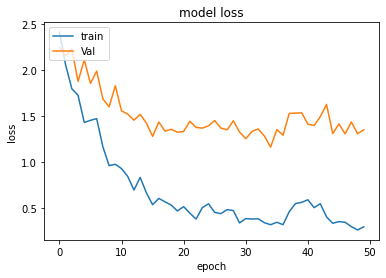

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x['loss'])
plt.plot(x['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')

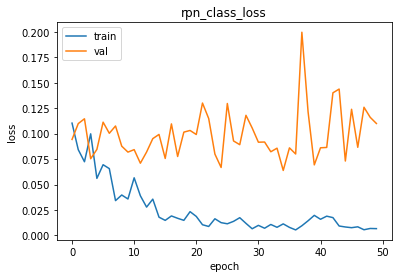

In [ ]:
plt.plot(x['rpn_class_loss'])
plt.plot(x['val_rpn_class_loss'])
plt.title('rpn_class_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

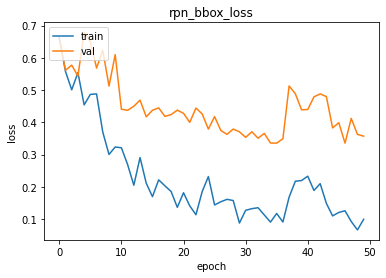

In [ ]:
plt.plot(x['rpn_bbox_loss'])
plt.plot(x['val_rpn_bbox_loss'])
plt.title('rpn_bbox_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

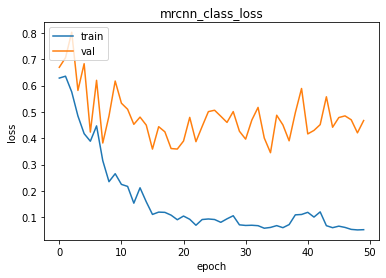

In [ ]:
plt.plot(x['mrcnn_class_loss'])
plt.plot(x['val_mrcnn_class_loss'])
plt.title('mrcnn_class_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

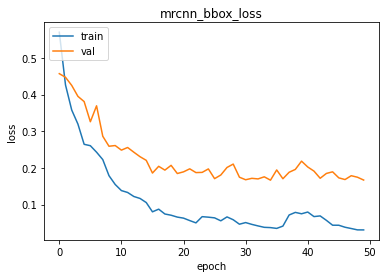

In [ ]:
plt.plot(x['mrcnn_bbox_loss'])
plt.plot(x['val_mrcnn_bbox_loss'])
plt.title('mrcnn_bbox_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

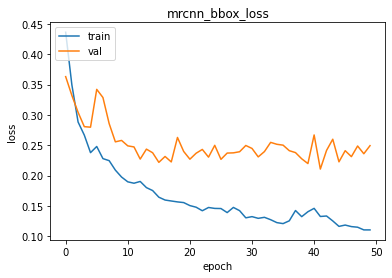

In [ ]:
plt.plot(x['mrcnn_mask_loss'])
plt.plot(x['val_mrcnn_mask_loss'])
plt.title('mrcnn_bbox_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

## Testing

In [11]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
# loading the trained weights o the custom dataset
model.load_weights('/content/gdrive/My Drive/mrotherwithoutmini.h5', by_name=True)
img = load_img("/content/gdrive/My Drive/images/1.jpg")
img = img_to_array(img)
# detecting objects in the image
result= model.detect([img])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


{'id': '826', 'source': 'dataset', 'path': '/content/gdrive/My Drive/images1/826.jpg', 'annotation': '/content/gdrive/My Drive/aimages1/826.xml'}
image ID: dataset.826 (106) /content/gdrive/My Drive/images1/826.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


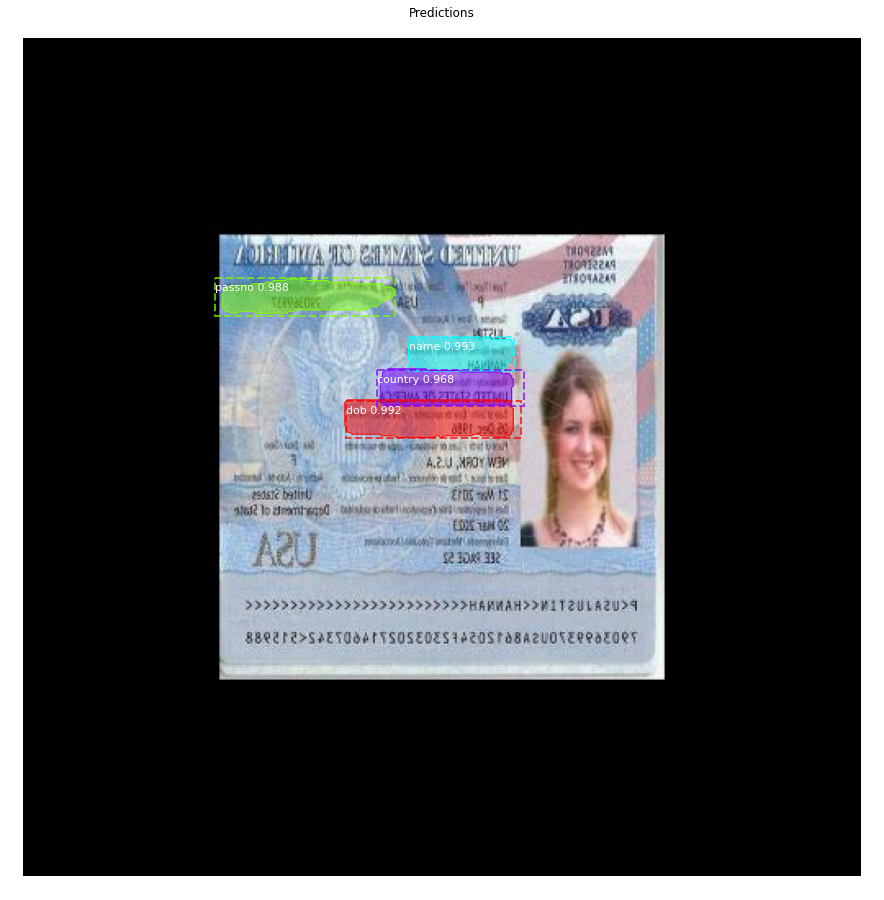

In [13]:
image_id = 106
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(test_set, config, image_id)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
# Display results

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], 
                            title="Predictions")

In [12]:
from mrcnn.model import load_image_gt
from mrcnn.utils import compute_ap
from statistics import mean
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)

		# make prediction
		yhat = model.detect([image], verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP


In [ ]:
train_mAP = evaluate_model(train_set, model,config)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, config)
print("Test mAP: %.3f" % test_mAP)

Train mAP: 0.955
Test mAP: 0.786


# IoU with the predicitons having the best confidence value selected

In [150]:
def iou_conf(dataset, model, cfg): #IoU
  IoUvals = {}
  conf = {}
  for image_id in dataset.image_ids:# Looping over images
    
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id)

    yhat = model.detect([image], verbose=0)
    r = yhat[0]
    origid=0 # GT-class Array index

    for id in gt_class_id:# Looping over GT-CLASSES in the image
      loc=np.where(r['class_ids']==id) #Find where this class exists in the predicted array
      max = -1
      maxind = -1
      for ind in loc[0]: #Looping over more than 1 of same class in predicted classes
        out = r['scores'][ind]
        if out>max: #Keep track of max confidence value in the predicted class
          max = out
          maxind = ind
      if (max != -1): #If the class exists in the predicted class, calculate IoU with the max confidence value
        nu=np.logical_and(gt_mask[:,:,origid],r['masks'][:,:,maxind])
        de=np.logical_or(gt_mask[:,:,origid],r['masks'][:,:,maxind])
        out = np.sum(nu)/np.sum(de) #IoU
        IoUvals[str(image_id)+':'+str(id)] = out
        conf[str(image_id)+':'+str(id)] = max
      origid=origid+1

  return IoUvals,conf

In [151]:
train_iou_conf,train_conf = iou_conf(train_set,model,config)

In [152]:
test_iou_conf,test_conf = iou_conf(test_set,model,config)

In [158]:
train_conf

{'0:1': 0.9999548,
 '0:2': 0.99987376,
 '0:3': 0.9996487,
 '0:4': 0.99692744,
 '1:1': 0.99986756,
 '1:2': 0.99996316,
 '1:4': 0.99988174,
 '1:3': 0.99963737,
 '2:1': 0.99997675,
 '2:2': 0.9999442,
 '2:3': 0.9995339,
 '2:4': 0.9996062,
 '3:1': 0.9998964,
 '3:2': 0.99983764,
 '3:3': 0.9998092,
 '3:4': 0.99987006,
 '4:1': 0.9998486,
 '4:2': 0.9996445,
 '4:3': 0.9998288,
 '4:4': 0.99964976,
 '5:1': 0.9998816,
 '5:3': 0.9997719,
 '5:4': 0.9993036,
 '6:1': 0.99995816,
 '6:2': 0.9999105,
 '6:3': 0.99977213,
 '6:4': 0.9989172,
 '7:1': 0.9998124,
 '7:2': 0.99929357,
 '7:4': 0.9988949,
 '7:3': 0.99866235,
 '8:1': 0.999974,
 '8:2': 0.99993813,
 '8:3': 0.99955565,
 '8:4': 0.9992551,
 '9:1': 0.9999845,
 '9:2': 0.9998739,
 '9:3': 0.99985886,
 '9:4': 0.99956113,
 '10:1': 0.99998057,
 '10:2': 0.9998066,
 '10:4': 0.9999335,
 '10:3': 0.99985325,
 '11:1': 0.9995982,
 '11:5': 0.99988496,
 '11:6': 0.99927396,
 '11:3': 0.9962754,
 '11:4': 0.9977336,
 '11:2': 0.9998529,
 '11:7': 0.99653375,
 '12:5': 0.999990

In [159]:
sum = 0 #Avg confidence per class for train
count = 0
avgtrain_conf = {}
for c in range(1,8):
  sum = 0
  count = 0
  for  a in range (0,717):
    if str(a)+':'+str(c) in train_conf:
      sum = sum + train_conf[str(a)+':'+str(c)]
      count = count+1
  avgtrain_conf[c]=sum/count


In [162]:
avgtrain_conf

{1: 0.9934893557749226,
 2: 0.9913541312761409,
 3: 0.9946304884315097,
 4: 0.9943636478815537,
 5: 0.9947403523855597,
 6: 0.9912445641929608,
 7: 0.9895021149663112}

In [163]:
sum = 0 #Avg confidence per class for test
count = 0
avgtest_conf= {}
for c in range(1,8):
  sum = 0
  count = 0
  for  a in range (0,249):
    if str(a)+':'+str(c) in test_conf:
      sum = sum + test_conf[str(a)+':'+str(c)]
      count = count+1
  avgtest_conf[c]=sum/count

In [164]:
avgtest_conf

{1: 0.9775090582459887,
 2: 0.9728455747570004,
 3: 0.9688283474044462,
 4: 0.9656971339310441,
 5: 0.9694286988062017,
 6: 0.9809118294715882,
 7: 0.9655051226417224}

In [165]:
class_pred_and_miss ={}
for a in range (0,249): #Classes missed per card
  count = 0
  count1= 0
  for c in range(1,8):
    if str(a)+':'+str(c) in test_iou_conf:
      count = count+1
    if str(a)+':'+str(c) in classes_not_classified_test:
      count1 = count1+1
  class_pred_and_miss[str(a)]=(count,count1)

In [166]:
class_pred_and_miss

{'0': (6, 0),
 '1': (6, 0),
 '10': (6, 0),
 '100': (5, 0),
 '101': (5, 0),
 '102': (4, 1),
 '103': (5, 0),
 '104': (5, 0),
 '105': (5, 0),
 '106': (4, 1),
 '107': (5, 0),
 '108': (4, 1),
 '109': (1, 3),
 '11': (6, 0),
 '110': (6, 0),
 '111': (6, 0),
 '112': (6, 0),
 '113': (6, 0),
 '114': (5, 1),
 '115': (6, 0),
 '116': (5, 1),
 '117': (4, 2),
 '118': (5, 1),
 '119': (6, 0),
 '12': (6, 0),
 '120': (6, 0),
 '121': (5, 1),
 '122': (6, 0),
 '123': (6, 0),
 '124': (6, 0),
 '125': (6, 0),
 '126': (4, 2),
 '127': (5, 1),
 '128': (5, 1),
 '129': (5, 1),
 '13': (6, 0),
 '130': (7, 0),
 '131': (7, 0),
 '132': (7, 0),
 '133': (7, 0),
 '134': (7, 0),
 '135': (7, 0),
 '136': (7, 0),
 '137': (7, 0),
 '138': (4, 1),
 '139': (7, 0),
 '14': (6, 0),
 '140': (6, 1),
 '141': (7, 0),
 '142': (7, 0),
 '143': (7, 0),
 '144': (7, 0),
 '145': (6, 1),
 '146': (4, 1),
 '147': (7, 0),
 '148': (7, 0),
 '149': (4, 0),
 '15': (5, 1),
 '150': (4, 0),
 '151': (4, 0),
 '152': (4, 0),
 '153': (4, 0),
 '154': (4, 0),
 '

In [153]:
sum = 0
count = 0
class_iou_train_conf = {} #Avg iou per class for train
for c in range(1,8):
  sum = 0
  count = 0
  for  a in range (0,717):
    if str(a)+':'+str(c) in train_iou_conf:
      sum = sum + train_iou_conf[str(a)+':'+str(c)]
      count = count+1
  class_iou_train_conf[c]=sum/count


In [154]:
sum = 0
count = 0
class_iou_test_conf = {} #Avg iou per class for test
for c in range(1,8):
  sum = 0
  count = 0
  for  a in range (0,249):
    if str(a)+':'+str(c) in test_iou_conf:
      sum = sum + test_iou_conf[str(a)+':'+str(c)]
      count = count+1
  class_iou_test_conf[c]=sum/count

In [155]:
class_iou_train_conf

{1: 0.848663737427293,
 2: 0.8629950474605557,
 3: 0.8721428003172143,
 4: 0.8702677789554727,
 5: 0.8705407831578116,
 6: 0.8438396268793862,
 7: 0.8678416680442962}

In [156]:
class_iou_test_conf

{1: 0.718363983362332,
 2: 0.7364394481252345,
 3: 0.7123315366517504,
 4: 0.7814714888051273,
 5: 0.7518372894238088,
 6: 0.7259614213299519,
 7: 0.7610738696960061}

In [115]:
len (train_iou_conf)

3802

In [116]:
len (test_iou_conf)

1144

In [ ]:
test_iou_conf

In [124]:
def Get_classes_not_classified(dataset, model, cfg):
  output = {}
  for image_id in dataset.image_ids:# Looping over images
    
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id)

    yhat = model.detect([image], verbose=0)
    r = yhat[0]
    origid=0 # GT-class Array index

    for id in gt_class_id:# Looping over GT-CLASSES in the image
      loc=np.where(r['class_ids']==id) #Find if this class exists in the predicted array
      if loc[0].size == 0:
        output[str(image_id)+':'+str(id)]=1
    origid=origid+1
  return output

In [125]:
classes_not_classified_test=Get_classes_not_classified(test_set,model,config)

In [126]:
classes_not_classified_train=Get_classes_not_classified(train_set,model,config)

In [134]:
len(classes_not_classified_test)

129

In [135]:
len(classes_not_classified_train)

109

In [136]:
classes_not_predicted_group_train = {} #Class instances per class not classified in train
for c in range(1,8):
  count1 = 0
  for  a in range (0,717):
    if str(a)+':'+str(c) in classes_not_classified_train:
        count1 = count1+1
  classes_not_predicted_group_train[c]=count1

In [137]:
classes_not_predicted_group_test = {} #Class instances per class not classified in test
for c in range(1,8):
  count1 = 0
  for  a in range (0,717):
    if str(a)+':'+str(c) in classes_not_classified_test:
        count1 = count1+1
  classes_not_predicted_group_test[c]=count1

In [138]:
classes_not_predicted_group_test

{1: 35, 2: 26, 3: 3, 4: 33, 5: 13, 6: 12, 7: 7}

In [139]:
classes_not_predicted_group_train

{1: 9, 2: 23, 3: 8, 4: 18, 5: 14, 6: 34, 7: 3}

In [144]:
classes_completely_wrongtrain = {}
for c in range(1,8):
  count1 = 0
  for  a in range (0,717):
    if str(a)+':'+str(c) in train_iou_conf:
      if train_iou_conf[str(a)+':'+str(c)]==0:
        count1 = count1+1
  classes_completely_wrongtrain[c]=count1

In [145]:
classes_completely_wrongtrain

{1: 3, 2: 20, 3: 3, 4: 0, 5: 2, 6: 2, 7: 2}

In [146]:
classes_completely_wrongtest = {}
for c in range(1,8):
  count1 = 0
  for  a in range (0,249):
    if str(a)+':'+str(c) in test_iou_conf:
      if test_iou_conf[str(a)+':'+str(c)]==0:
        count1 = count1+1
  classes_completely_wrongtest[c]=count1

In [147]:
classes_completely_wrongtest

{1: 22, 2: 23, 3: 18, 4: 10, 5: 5, 6: 0, 7: 4}

# This part is not used in the report but was just tested and found out to have similar results to the much quicker training model we used first

## 1024 max dim , MaskRCNN on various augmentations --> Had similar results as the previous ones so we just chose the previous one as it takes less time to train

In [ ]:
class myMaskRCNNConfig2(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes
     # name dob cnic country passno, address, surname + BG
    NUM_CLASSES = 7+1
   
    # Number of training steps per epoch (Images per epoch)
    STEPS_PER_EPOCH = 100
    # Learning rate
    LEARNING_RATE=0.002
    BACKBONE = 'resnet50' #BackBone
    # Skip detections with < 70% confidence
    DETECTION_MIN_CONFIDENCE = 0.7
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

In [ ]:
config2 = myMaskRCNNConfig2()

In [ ]:
config2.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [ ]:
model2 = modellib.MaskRCNN(mode="training", config=config2, model_dir='./')

In [ ]:
model2.load_weights('/content/gdrive/My Drive/mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
model2.train(train_set, test_set, learning_rate=0.002, epochs=50, layers='heads')
history = model.keras_model.history.history


Starting at epoch 0. LR=0.002

Checkpoint Path: ./maskrcnn_config20210602T1302/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (Time

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_4/SGD/gradients/gradients/roi_align_classifier_3/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_4/SGD/gradients/gradients/roi_align_classifier_3/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_4/SGD/gradients/gradients/roi_align_classifier_3/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_4/SGD/gradients/gradients/roi_align_classifier_3/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training_4/SGD/gradients/grad

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 2.5958 - rpn_class_loss: 0.1610 - rpn_bbox_loss: 0.6367 - mrcnn_class_loss: 0.7833 - mrcnn_bbox_loss: 0.5656 - mrcnn_mask_loss: 0.4491

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


100/100 [==============================] - 220s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 2.5958 - rpn_class_loss: 0.1610 - rpn_bbox_loss: 0.6367 - mrcnn_class_loss: 0.7833 - mrcnn_bbox_loss: 0.5656 - mrcnn_mask_loss: 0.4491 - val_loss: 2.4521 - val_rpn_class_loss: 0.0462 - val_rpn_bbox_loss: 0.5578 - val_mrcnn_class_loss: 0.8887 - val_mrcnn_bbox_loss: 0.5142 - val_mrcnn_mask_loss: 0.4452
Epoch 2/50
100/100 [==============================] - 145s 1s/step - batch: 49.5000 - size: 1.0000 - loss: 1.9336 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 0.5510 - mrcnn_class_loss: 0.6003 - mrcnn_bbox_loss: 0.3644 - mrcnn_mask_loss: 0.3536 - val_loss: 2.2950 - val_rpn_class_loss: 0.1174 - val_rpn_bbox_loss: 0.7651 - val_mrcnn_class_loss: 0.5417 - val_mrcnn_bbox_loss: 0.4765 - val_mrcnn_mask_loss: 0.3944
Epoch 3/50
100/100 [==============================] - 147s 1s/step - batch: 49.5000 - size: 1.0000 - loss: 1.7313 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 0.4774 - mrcnn_class_loss: 0.5664 - m

In [ ]:
model_path = '/content/gdrive/My Drive/mrother1024'  + '.' + str(time.time()) + '.h5'
model.keras_model.save_weights(model_path)

In [ ]:
  import pickle
  with open('/content/gdrive/My Drive/trainHistoryDictother1024', 'wb') as file_pi:
    pickle.dump(history, file_pi)

In [ ]:
config2.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [ ]:
import pickle
with (open("/content/gdrive/My Drive/trainHistoryDictother1024", "rb")) as openfile:
  x = pickle.load(openfile)

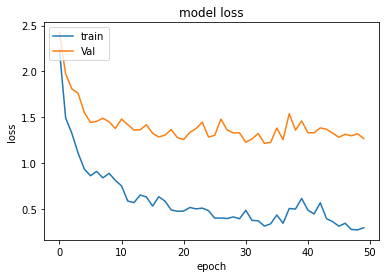

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x['loss'])
plt.plot(x['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')

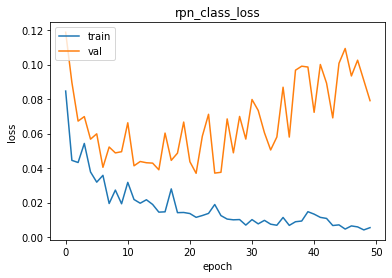

In [ ]:
plt.plot(x['rpn_class_loss'])
plt.plot(x['val_rpn_class_loss'])
plt.title('rpn_class_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

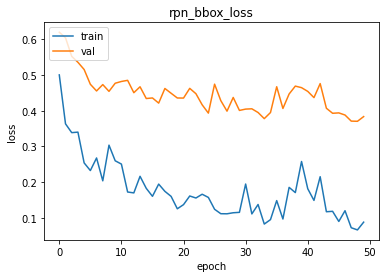

In [ ]:
plt.plot(x['rpn_bbox_loss'])
plt.plot(x['val_rpn_bbox_loss'])
plt.title('rpn_bbox_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

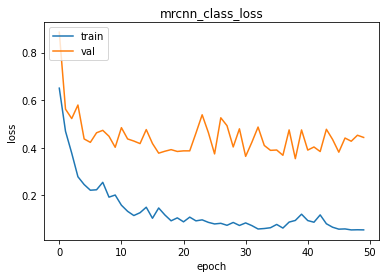

In [ ]:
plt.plot(x['mrcnn_class_loss'])
plt.plot(x['val_mrcnn_class_loss'])
plt.title('mrcnn_class_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

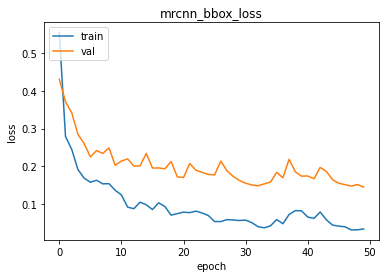

In [ ]:
plt.plot(x['mrcnn_bbox_loss'])
plt.plot(x['val_mrcnn_bbox_loss'])
plt.title('mrcnn_bbox_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

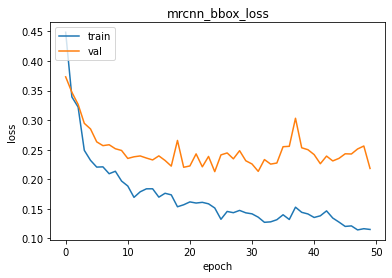

In [ ]:
plt.plot(x['mrcnn_mask_loss'])
plt.plot(x['val_mrcnn_mask_loss'])
plt.title('mrcnn_bbox_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


{'id': '826', 'source': 'dataset', 'path': '/content/gdrive/My Drive/images1/826.jpg', 'annotation': '/content/gdrive/My Drive/aimages1/826.xml'}
image ID: dataset.826 (106) /content/gdrive/My Drive/images1/826.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


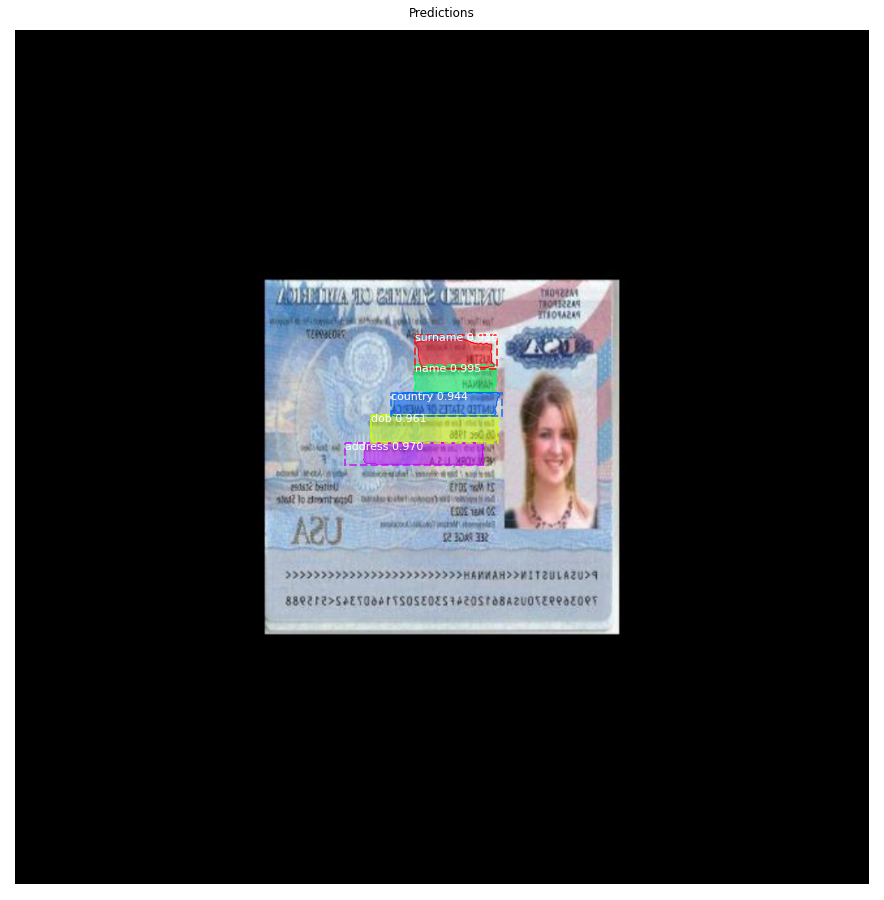

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config2, model_dir='./')
# loading the trained weights o the custom dataset
model.load_weights('/content/gdrive/My Drive/mrother1024.1622646495.844454.h5', by_name=True)
img = load_img("/content/gdrive/My Drive/images1/6.jpg")
img = img_to_array(img)
# detecting objects in the image
result= model.detect([img])
image_id = 106
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(test_set, config2, image_id)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
# Display results

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], 
                            title="Predictions")

# End

{'id': '720', 'source': 'dataset', 'path': '/content/gdrive/My Drive/images1/720.jpg', 'annotation': '/content/gdrive/My Drive/aimages1/720.xml'}
image ID: dataset.720 (0) /content/gdrive/My Drive/images1/720.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


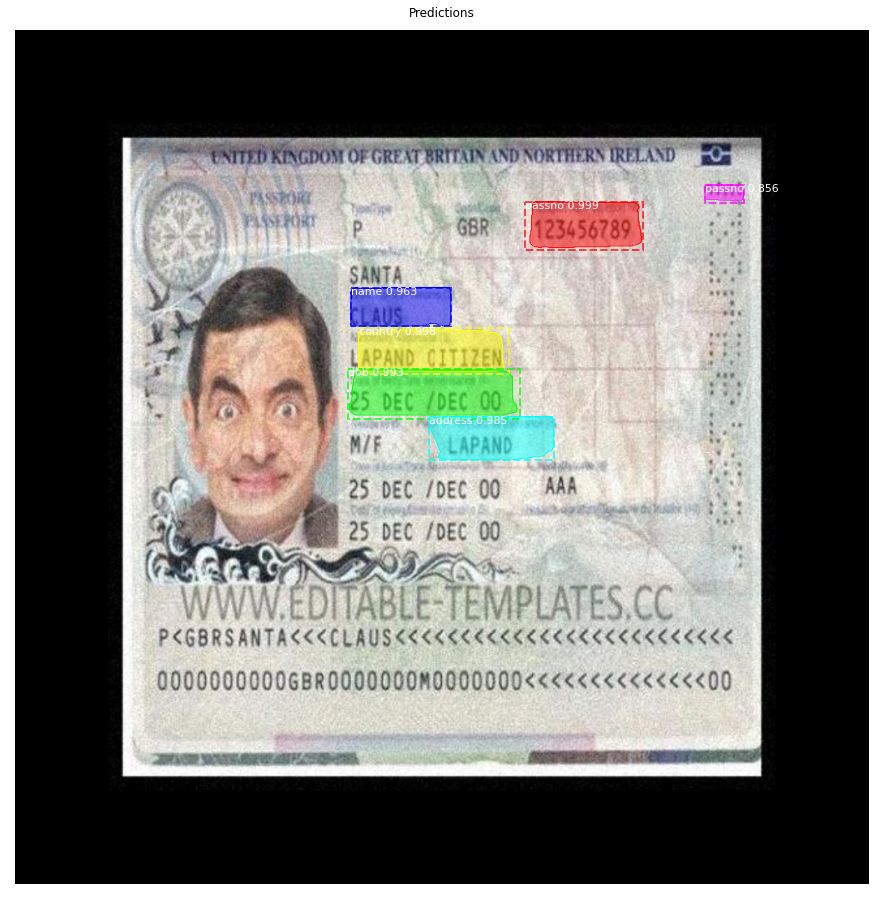

(1024, 1024, 6) ['BG', 'name', 'country', 'cnic', 'dob', 'surname', 'passno', 'address'] [0.99909484 0.9980844  0.9932681  0.985473   0.96316916 0.8563368 ]


In [ ]:
img = load_img("/content/gdrive/My Drive/images1/1.jpg")
img = img_to_array(img)
# detecting objects in the image
result= model.detect([img])
image_id = 0
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(test_set, config2, image_id)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
# Display results

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], 
                            title="Predictions")
print(r['masks'].shape, 
                            test_set.class_names, r['scores'])